In [3]:
#install Prophet 
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [prophet]m3/4 [prophet]]


In [9]:
import sys
print(sys.executable)  # Shows which Python interpreter is being used

import sys
!{sys.executable} -m pip install prophet

!{sys.executable} -m pip install plotly

/Users/channiechen/myenv/bin/python3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 43.1 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [plotly]2m1/2 [plotly]


In [57]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime
from prophet.diagnostics import cross_validation

%matplotlib inline

In [25]:
# Load Kaggle dataset files (ensure these are in your project directory)
try:
    train = pd.read_csv('train.csv')
    stores = pd.read_csv('stores.csv')
    holidays = pd.read_csv('holidays_events.csv')
    oil = pd.read_csv('oil.csv')
    transactions = pd.read_csv('transactions.csv')
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure all CSV files are in the project directory.")
    exit(1)

In [26]:
# Diagnostic: Check columns and sample data
print("Columns in train.csv:", train.columns.tolist())
print("Sample dates in train.csv:", train['date'].head().tolist())
print("Columns in oil.csv:", oil.columns.tolist())
print("Sample dates in oil.csv:", oil['date'].head().tolist())
print("Columns in holidays_events.csv:", holidays.columns.tolist())
print("Columns in stores.csv:", stores.columns.tolist())
print("Columns in transactions.csv:", transactions.columns.tolist())

Columns in train.csv: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']
Sample dates in train.csv: ['2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01']
Columns in oil.csv: ['date', 'dcoilwtico']
Sample dates in oil.csv: ['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-07']
Columns in holidays_events.csv: ['date', 'type', 'locale', 'locale_name', 'description', 'transferred']
Columns in stores.csv: ['store_nbr', 'city', 'state', 'type', 'cluster']
Columns in transactions.csv: ['date', 'store_nbr', 'transactions']


In [27]:
# Rename 'type' columns to avoid conflicts
stores = stores.rename(columns={'type': 'store_type'})
holidays = holidays.rename(columns={'type': 'holiday_type'})

In [28]:
# Ensure date columns are in datetime format
try:
    train['date'] = pd.to_datetime(train['date'])
    oil['date'] = pd.to_datetime(oil['date'])
    holidays['date'] = pd.to_datetime(holidays['date'])
    transactions['date'] = pd.to_datetime(transactions['date'])
except KeyError as e:
    print(f"Error: {e}. Check if 'date' column exists in all files.")
    exit(1)

In [30]:
# Merge datasets
data = train.merge(stores, on='store_nbr', how='left')
print("Columns after train-stores merge:", data.columns.tolist())
if 'date' not in data.columns or 'date' not in oil.columns:
    print("Error: 'date' column missing in data or oil DataFrame.")
    exit(1)
data = data.merge(oil, on='date', how='left')
data = data.merge(transactions, on=['date', 'store_nbr'], how='left')
data = data.merge(holidays, on='date', how='left')

# Diagnostic: Check merged data columns
print("Columns in merged data:", data.columns.tolist())

Columns after train-stores merge: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state', 'store_type', 'cluster']
Columns in merged data: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state', 'store_type', 'cluster', 'dcoilwtico', 'transactions', 'holiday_type', 'locale', 'locale_name', 'description', 'transferred']


In [31]:
# Preprocess data
data['dcoilwtico'] = data['dcoilwtico'].interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')  # Handle missing oil prices
data['transactions'] = data['transactions'].fillna(data['transactions'].mean())  # Fill missing transactions
# Create holiday indicator
if 'holiday_type' in data.columns:
    data['holiday'] = data['holiday_type'].notnull().astype(int)
else:
    print("Warning: 'holiday_type' column missing, setting holiday to 0")
    data['holiday'] = 0
data['onpromotion'] = data['onpromotion'].fillna(0)  # Ensure no missing promotions

/var/folders/wx/_c13by7j3bz3c90nb55phskr0000gn/T/ipykernel_85116/301498188.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['dcoilwtico'] = data['dcoilwtico'].interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')  # Handle missing oil prices


In [32]:
# Select a single store-item combination for demonstration (Store 1, BEVERAGES)
prophet_data = data[(data['store_nbr'] == 1) & (data['family'] == 'BEVERAGES')].copy()
prophet_data = prophet_data[['date', 'sales', 'onpromotion', 'dcoilwtico', 'holiday', 'transactions']].rename(columns={'date': 'ds', 'sales': 'y'})

In [33]:
# Feature engineering
prophet_data['month'] = prophet_data['ds'].dt.month  # Add month as a regressor
prophet_data['day_of_week'] = prophet_data['ds'].dt.dayofweek  # Add day of week
prophet_data['lag1'] = prophet_data['y'].shift(1)  # Lagged sales (1 day)
prophet_data = prophet_data.dropna()  # Remove rows with NaN

In [34]:
model = Prophet(
    growth='linear',
    seasonality_mode='additive',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    interval_width=0.95
)

In [35]:
# Add regressors
regressors = ['onpromotion', 'dcoilwtico', 'holiday', 'transactions', 'month', 'day_of_week', 'lag1']
for regressor in regressors:
    model.add_regressor(regressor, mode='additive')

In [36]:
# Fit model
model.fit(prophet_data)


23:17:16 - cmdstanpy - INFO - Chain [1] start processing
23:17:17 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
# Function to calculate RMSSE
def calculate_rmsse(actual, predicted, train, horizon):
    """
    Calculate RMSSE for a single time series.
    actual: Array of actual values in forecast period
    predicted: Array of predicted values
    train: Array of training values (historical sales)
    horizon: Forecast horizon (number of periods)
    """
    # Mean squared error of forecast
    mse = np.mean((actual - predicted) ** 2)
    
    # Mean squared error of naive forecast (using previous day's sales)
    naive_mse = np.mean((train[1:] - train[:-1]) ** 2) if len(train) > 1 else 1e-10  # Avoid division by zero
    
    # RMSSE
    rmsse = np.sqrt(mse / naive_mse) if naive_mse != 0 else np.inf
    return rmsse

23:42:00 - cmdstanpy - INFO - Chain [1] start processing
23:42:00 - cmdstanpy - INFO - Chain [1] start processing
23:42:00 - cmdstanpy - INFO - Chain [1] start processing
23:42:00 - cmdstanpy - INFO - Chain [1] start processing
23:42:00 - cmdstanpy - INFO - Chain [1] done processing
23:42:00 - cmdstanpy - INFO - Chain [1] done processing
23:42:01 - cmdstanpy - INFO - Chain [1] done processing
23:42:01 - cmdstanpy - INFO - Chain [1] done processing


           ds         yhat   yhat_lower   yhat_upper       y     cutoff
0  2016-02-07  1093.406846   564.450464  1643.908328   639.0 2016-02-06
1  2016-02-08  1011.413677   473.965626  1575.406519   531.0 2016-02-06
2  2016-02-09   488.711301  -114.520376  1062.422807   742.0 2016-02-06
3  2016-02-10  1479.070596   891.339743  2050.572829  2247.0 2016-02-06
4  2016-02-11  2023.979379  1433.969225  2583.725945  2085.0 2016-02-06
..        ...          ...          ...          ...     ...        ...
59 2017-08-11  1545.287865   891.613529  2184.804838  1006.0 2017-07-30
60 2017-08-12  1500.547872   878.283104  2123.630843  1659.0 2017-07-30
61 2017-08-13   857.876932   239.684131  1494.357783   803.0 2017-07-30
62 2017-08-14  1900.808305  1263.932335  2509.316463  2201.0 2017-07-30
63 2017-08-15  2026.525753  1402.729823  2633.669025  1942.0 2017-07-30

[64 rows x 6 columns]


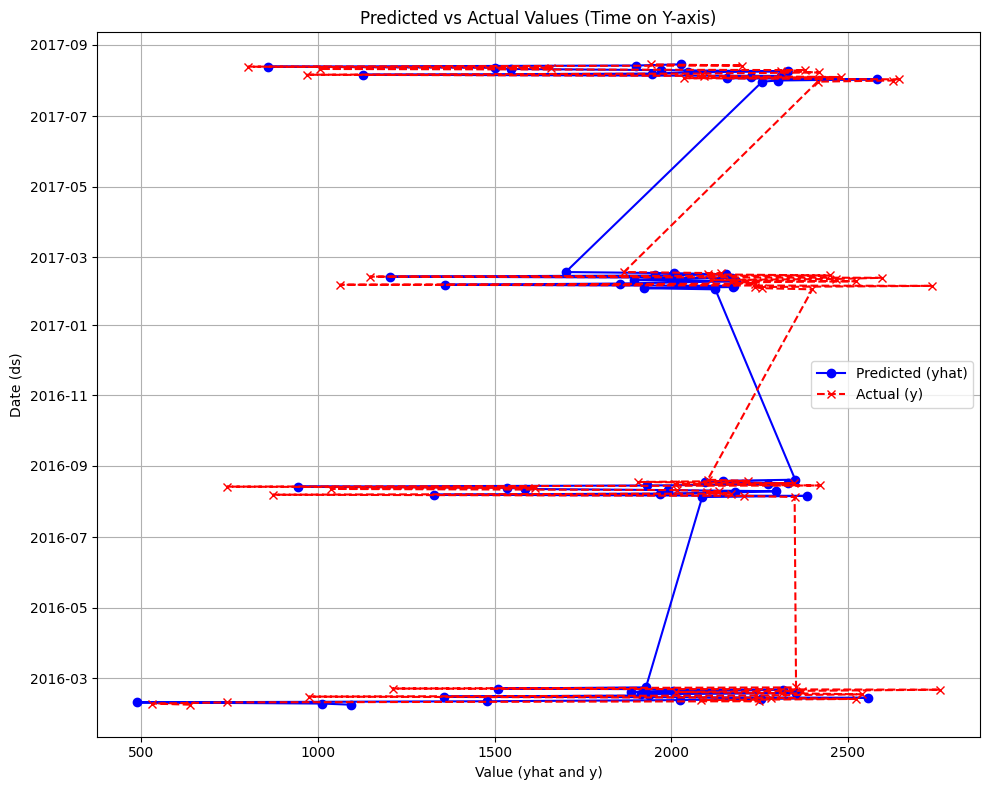

In [61]:
cv_results = cross_validation(
    model,
    initial='1095 days',
    period='180 days',
    horizon='16 days',
    parallel="processes"
)

print(cv_results)

plt.figure(figsize=(10, 8))  # Taller figure for dates on y-axis
plt.plot(cv_results['yhat'], cv_results['ds'], label='Predicted (yhat)', color='blue', marker='o', linestyle='-')
plt.plot(cv_results['y'], cv_results['ds'], label='Actual (y)', color='red', marker='x', linestyle='--')

plt.xlabel('Value (yhat and y)')  # Now x-axis shows values
plt.ylabel('Date (ds)')           # y-axis shows time
plt.title('Predicted vs Actual Values (Time on Y-axis)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
rmsse_scores = []
for cutoff in cv_results['cutoff'].unique():
    cv_subset = cv_results[cv_results['cutoff'] == cutoff]
    actual = cv_subset['y'].values
    predicted = cv_subset['yhat'].values
    # Use training data up to cutoff for naive forecast denominator
    train_subset = prophet_data[prophet_data['ds'] <= cutoff]['y'].values
    rmsse = calculate_rmsse(actual, predicted, train_subset, horizon=len(actual))
    rmsse_scores.append(rmsse)

# Average RMSSE
mean_rmsse = np.mean(rmsse_scores)
print(f"Mean RMSSE: {mean_rmsse:.4f}")

Mean RMSSE: 0.5038


In [37]:
# Create future dataframe for forecasting (30 days ahead)
future = model.make_future_dataframe(periods=30, freq='D')
future = future.merge(prophet_data[['ds', 'onpromotion', 'dcoilwtico', 'holiday', 'transactions', 'month', 'day_of_week', 'lag1']], on='ds', how='left')

In [38]:
# Fill future regressors
future['onpromotion'] = future['onpromotion'].fillna(prophet_data['onpromotion'].mean())
future['dcoilwtico'] = future['dcoilwtico'].fillna(prophet_data['dcoilwtico'].mean())
future['holiday'] = future['holiday'].fillna(0)
future['transactions'] = future['transactions'].fillna(prophet_data['transactions'].mean())
future['month'] = future['ds'].dt.month
future['day_of_week'] = future['ds'].dt.dayofweek
future['lag1'] = future['lag1'].fillna(prophet_data['y'].iloc[-1])

In [40]:
# Generate forecast
forecast = model.predict(future)

print(forecast)

             ds        trend   yhat_lower   yhat_upper  trend_lower  \
0    2013-01-02  1096.188224   112.511147  1401.055465  1096.188224   
1    2013-01-03  1096.267038   245.160546  1508.736295  1096.267038   
2    2013-01-04  1096.345853   502.279799  1661.957783  1096.345853   
3    2013-01-05  1096.424667   557.700704  1776.078810  1096.424667   
4    2013-01-06  1096.503482  -451.625448   769.518045  1096.503482   
...         ...          ...          ...          ...          ...   
1738 2017-09-10  1966.034326  1271.433715  2560.115858  1963.725390   
1739 2017-09-11  1966.107450  1915.004251  3184.331480  1963.694733   
1740 2017-09-12  1966.180573  1474.802780  2667.715658  1963.577512   
1741 2017-09-13  1966.253696  1623.091241  2813.605947  1963.538914   
1742 2017-09-14  1966.326819  1340.782306  2604.961830  1963.469166   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0     1096.188224     -305.942049           -305.942049           

In [50]:
fig = model.plot(forecast)
plt.title('Prophet Forecast for Store 1, BEVERAGES')
plt.savefig('prophet_forecast.png')
plt.close()

In [51]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('prophet_forecast.csv', index=False)
cv_results[['ds', 'y', 'yhat', 'cutoff']].to_csv('prophet_cv_results.csv', index=False)
print("Forecast saved to 'prophet_forecast.csv'")
print("Cross-validation results saved to 'prophet_cv_results.csv'")

Forecast saved to 'prophet_forecast.csv'
Cross-validation results saved to 'prophet_cv_results.csv'
